# Predicting Wine Quality Using Multiple Linear Regression
Group 7: Rui Xiang Yu, Rico Chan, & Kevin Yu  
Course: DSCI 310, 2024 Winter Term 2

## 1. Summary

This project analyzes different properties of wine and analyzes which properties affect the quality of wine positively and which properties affect it negatively. We applied a multiple linear regression on a public-use dataset to discover how each property affects the quality of wine. Splitting the dataset into a 75/25 training/testing split, and applying a specified recipe for a multivariate regression, we obtained decent RMSE and MAE values of 0.67 and 0.52 respectively, but a mediocre R-squared value of 0.32. We discover that the fixed acidity, residual sugar, free sulphur dioxide, sulphates, and the alcohol properties tend to increase the wine quality, while the volatile acidity, citric acid, chlorides, total sulphur dioxide, density, and pH properties tend to reduce the wine quality. 

## 2. Introduction
Wine is entrenched in many cultures and remains a strong industry worldwide (Eflman, 2017; *Culture of wine, 2020*). Technological innovations have supported the growth of the wine industry, especially in the realm of certification and quality assessment (Cortez et al., 2009). One prominent innovation is the use of laboratory testing to relate physicochemical properties of wine to human sensory perceptions (Cortez et al., 2009; Luque et al., 2023). Examples of physicochemical indicators include pH and and residual sugar. Using data to model complex wine perceptions is a daunting task, but it can benefit wine production by flagging the most important properties to consider and informing price setting (Cortez et al., 2009).

Thus, our key question is: **Can we use multiple linear regression and various physicochemical indicators to predict the quality of red wine?**

To answer whether a full regression model is viable, we use a dataset on red wine quality [from the UCI Machine Learning Repository](https://doi.org/10.24432/C56S3T). The dataset comprises of 12 variables (11 physicochemical indicators and 1 quality indicator) and contains 1599 instances of red vinho verde, a popular wine from Portugal. Each instance of wine was assessed by at least three sensory assessors and scored on a ten point scale that ranges from "very bad" to "excellent"; the wine quality for each instance is determined by the median of these scores (Cortez et al., 2009). The data was collected by the CVRVV, an inter-professional organisation dedicated to the promotion of vinho verde, from  May 2004 to February 2007.

## 3. Methods

### 3.1. Loading Data
From UCI Machine Learning Repository: <https://doi.org/10.24432/C56S3T>

In [4]:
# Import packages
library(tidyverse)
library(tidymodels)
library(cowplot)
library(car)
library(corrplot)

corrplot 0.92 loaded



In [13]:
# Read CSV data.
wine <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
                delim = ";")

# Adding new names as the original names contain spaces.
new_names <- c("fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", "free_sulfur_dioxide", 
              "total_sulfur_dioxide", "density", "pH", "sulphates", "alcohol", "quality")
colnames(wine) <- new_names

# Previewing the first 6 rows.
head(wine)

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


> *Table 1. Loaded dataset of wine quality.*

### 3.2. Exploratory Data Analysis

We first set a seed to ensure reproducibility. We then split the data into a training set (75% of the dataset) and a testing set (the remaining 25%). We check the number of rows for each training and testing dataset to make sure the split was done correctly. The training set will be used to train our model. The testing set will be used to validate the results of our model.

In [14]:
# Setting the seed.
set.seed(7)

# Splitting the data.
wine_split <- initial_split(wine, prop = 0.75, strata = quality)
wine_train <- training(wine_split)
wine_test <- testing(wine_split)

nrow(wine_train)
nrow(wine_test)

[1] 1198

[1] 401

As we can see, the split was done appropriately. We can now move on to see if there are any missing values in our entire dataset:

In [15]:
sum(is.na(wine))

[1] 0

... And summary statistics.

In [16]:
# Summary Statistics
summary(wine_train)

 fixed_acidity    volatile_acidity  citric_acid     residual_sugar  
 Min.   : 4.600   Min.   :0.1200   Min.   :0.0000   Min.   : 0.900  
 1st Qu.: 7.100   1st Qu.:0.3900   1st Qu.:0.0925   1st Qu.: 1.900  
 Median : 7.900   Median :0.5200   Median :0.2600   Median : 2.200  
 Mean   : 8.325   Mean   :0.5253   Mean   :0.2721   Mean   : 2.534  
 3rd Qu.: 9.200   3rd Qu.:0.6350   3rd Qu.:0.4275   3rd Qu.: 2.600  
 Max.   :15.600   Max.   :1.3300   Max.   :1.0000   Max.   :15.500  
   chlorides       free_sulfur_dioxide total_sulfur_dioxide    density      
 Min.   :0.01200   Min.   : 1.00       Min.   :  6.00       Min.   :0.9901  
 1st Qu.:0.07000   1st Qu.: 7.00       1st Qu.: 22.00       1st Qu.:0.9956  
 Median :0.07900   Median :14.00       Median : 38.00       Median :0.9968  
 Mean   :0.08754   Mean   :15.92       Mean   : 46.56       Mean   :0.9968  
 3rd Qu.:0.09100   3rd Qu.:22.00       3rd Qu.: 62.00       3rd Qu.:0.9978  
 Max.   :0.61000   Max.   :72.00       Max.   :278.00  

> *Figure 1. Summary statistics of wine dataset.*

Next, we examine the means of the independent variables for every level of our response variable "quality".

In [17]:
# Means for each level of response variable "quality"
response_means <- wine_train %>%
mutate(quality = as.factor(quality)) %>%
group_by(quality) %>%
summarise_all(mean)

response_means

quality,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,8.444444,0.8072222,0.1900000,2.694444,0.12088889,11.66667,26.66667,0.9977644,3.386667,0.5888889,9.850000
4,7.653846,0.6748718,0.1871795,2.823077,0.09584615,11.82051,36.38462,0.9965918,3.386667,0.6153846,10.333333
5,8.150392,0.5789804,0.2440588,2.533922,0.09399216,17.08627,56.34216,0.9971438,3.305039,0.6278431,9.880196
6,8.410879,0.4951883,0.2752092,2.451464,0.08390377,15.85460,41.37029,0.9966474,3.313431,0.6771967,10.608543
7,8.850993,0.3912914,0.3796689,2.709934,0.07459603,13.49338,34.15232,0.9960086,3.282252,0.7486093,11.483554
8,7.709091,0.4263636,0.3336364,2.545455,0.06700000,15.72727,40.72727,0.9942845,3.319091,0.7709091,12.481818


> *Table 2. Means for each level of the response variable "quality".*

### 3.3. Exploratory Data Analysis Visualization



Before we begin on the analysis, we wanted to visualize our dataset to get a general understanding of our data and check for valid assumptions and potential issues we have to alleviate later on.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


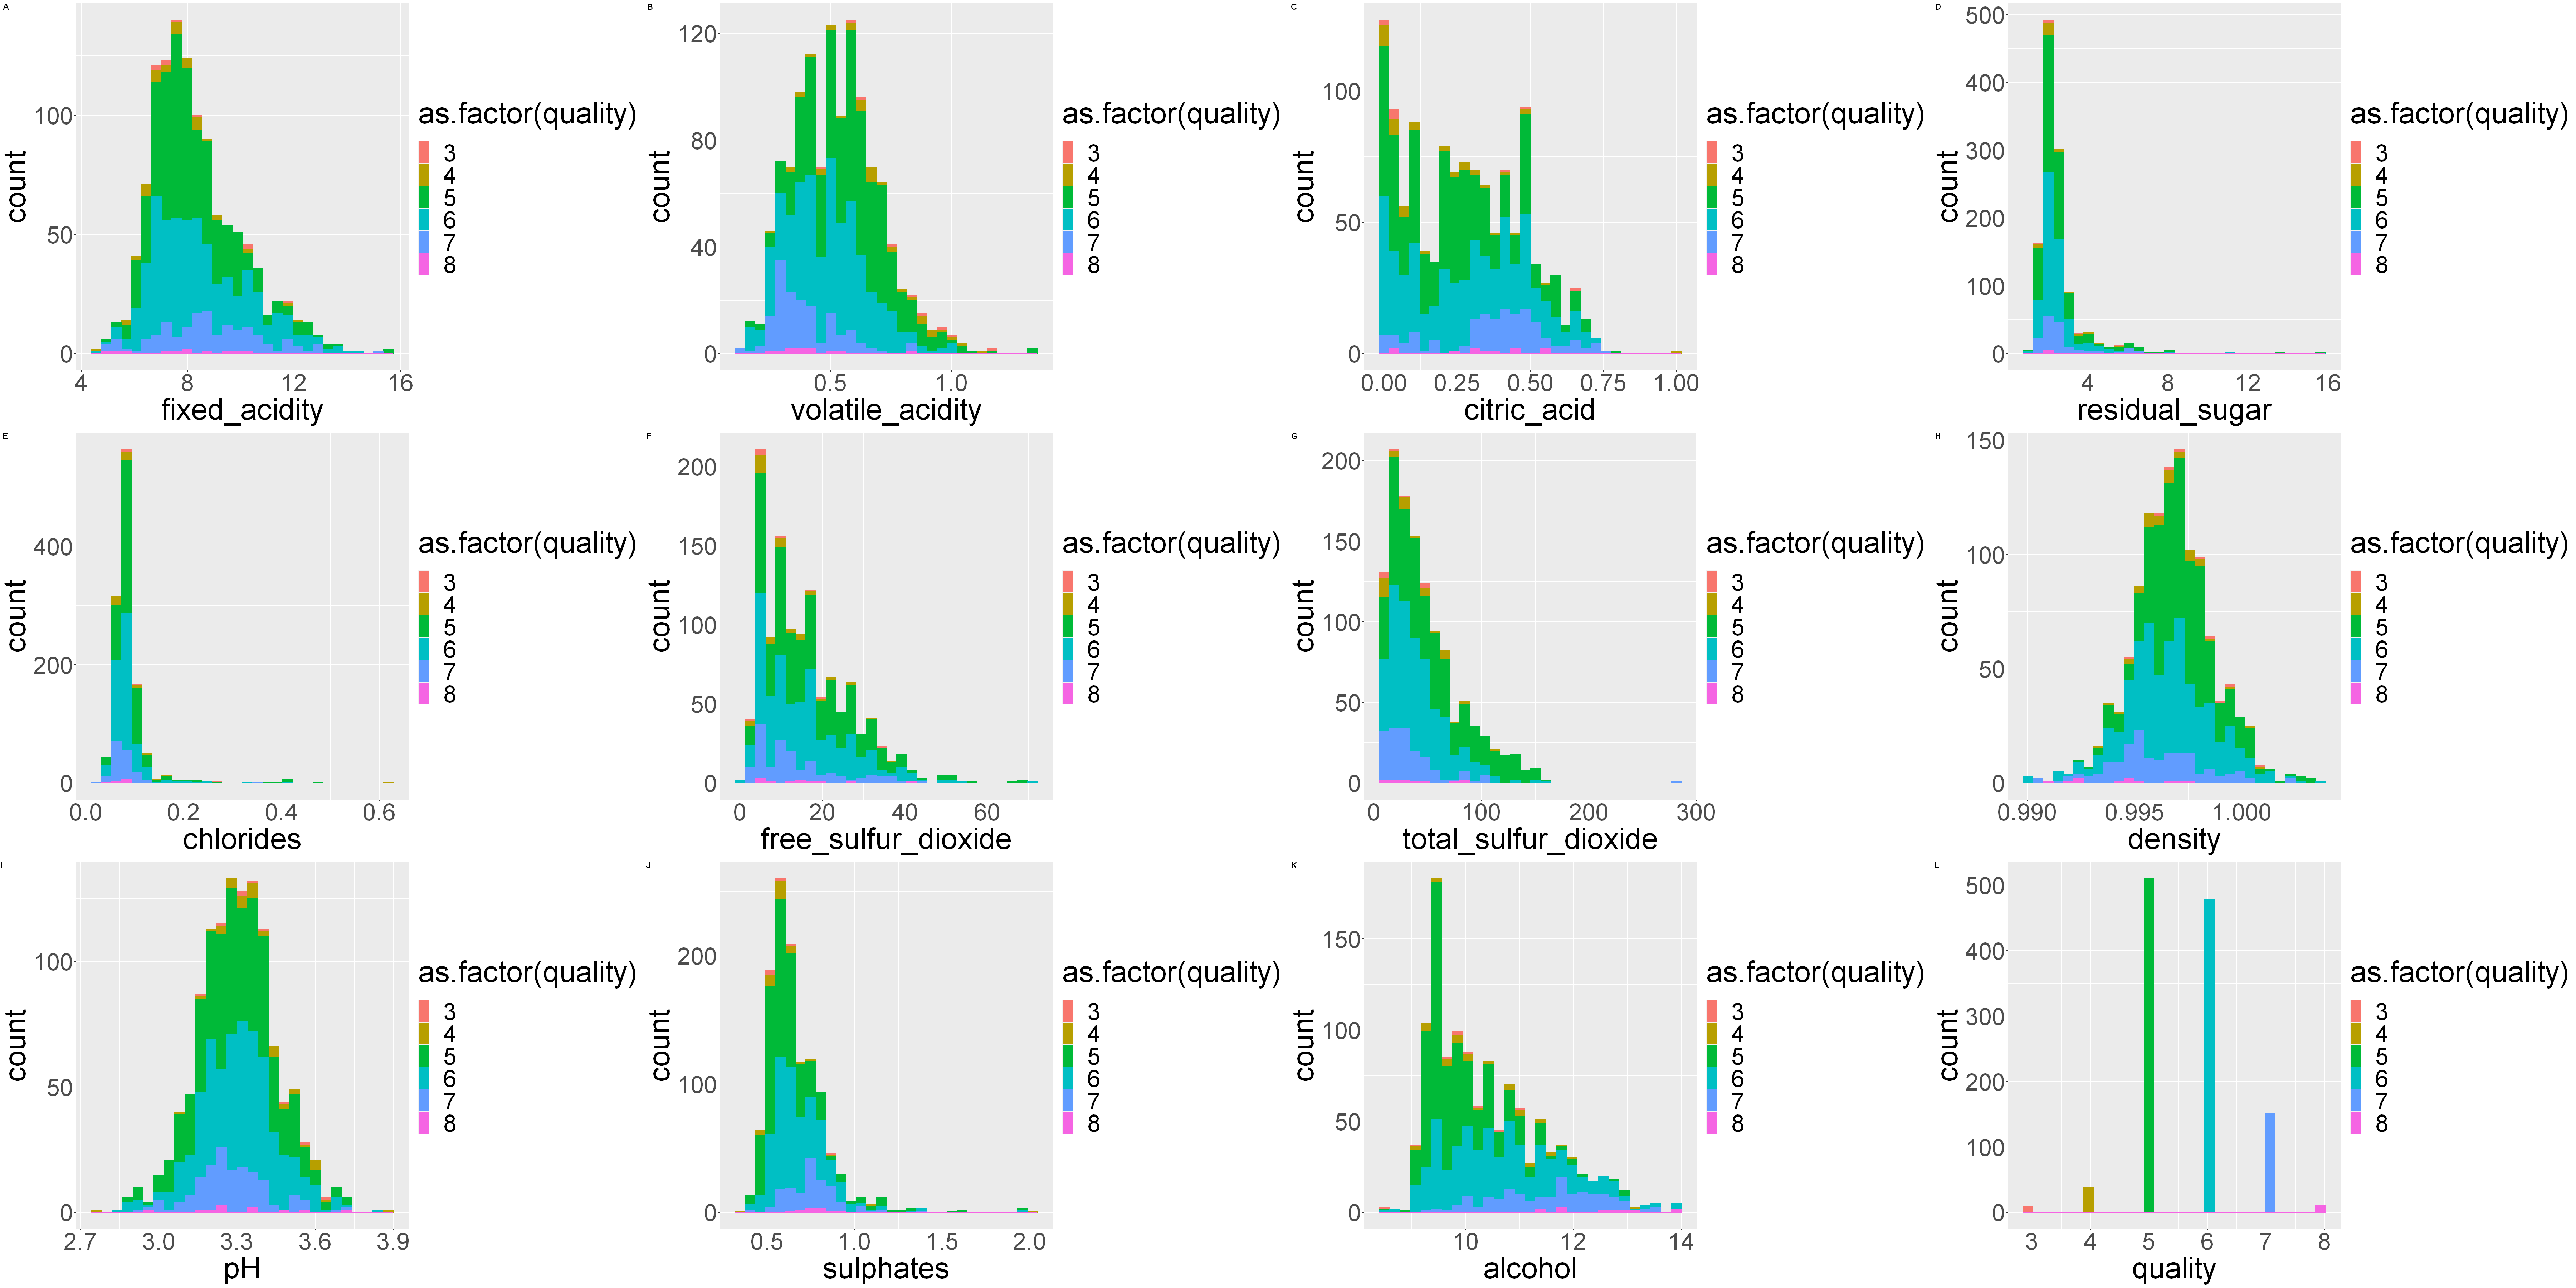

In [18]:
font_size = 50

options(repr.plot.width = 60, repr.plot.height = 30)

fixed_acidity_plot <- wine_train %>%
    ggplot(aes(x = fixed_acidity)) +
    geom_histogram(aes(color = as.factor(quality), fill = as.factor(quality))) + 
    theme(text = element_text(size=font_size))

volatile_acidity_plot <- wine_train %>%
    ggplot(aes(x = volatile_acidity)) +
    geom_histogram(aes(color = as.factor(quality), fill = as.factor(quality))) + 
    theme(text = element_text(size=font_size))

citric_acid_plot <- wine_train %>%
    ggplot(aes(x = citric_acid)) +
    geom_histogram(aes(color = as.factor(quality), fill = as.factor(quality))) + 
    theme(text = element_text(size=font_size))

residual_sugar_plot <- wine_train %>%
    ggplot(aes(x = residual_sugar)) +
    geom_histogram(aes(color = as.factor(quality), fill = as.factor(quality))) + 
    theme(text = element_text(size=font_size))

chlorides_plot <- wine_train %>%
    ggplot(aes(x = chlorides)) +
    geom_histogram(aes(color = as.factor(quality), fill = as.factor(quality))) + 
    theme(text = element_text(size=font_size))

free_sulfur_dioxide_plot <- wine_train %>%
    ggplot(aes(x = free_sulfur_dioxide)) +
    geom_histogram(aes(color = as.factor(quality), fill = as.factor(quality))) + 
    theme(text = element_text(size=font_size))

total_sulfur_dioxide_plot <- wine_train %>%
    ggplot(aes(x = total_sulfur_dioxide)) +
    geom_histogram(aes(color = as.factor(quality), fill = as.factor(quality))) + 
    theme(text = element_text(size=font_size))

density_plot <- wine_train %>%
    ggplot(aes(x = density)) +
    geom_histogram(aes(color = as.factor(quality), fill = as.factor(quality))) + 
    theme(text = element_text(size=font_size))

pH_plot <- wine_train %>%
    ggplot(aes(x = pH)) +
    geom_histogram(aes(color = as.factor(quality), fill = as.factor(quality))) + 
    theme(text = element_text(size=font_size))

sulphates_plot <- wine_train %>%
    ggplot(aes(x = sulphates)) +
    geom_histogram(aes(color = as.factor(quality), fill = as.factor(quality))) + 
    theme(text = element_text(size=font_size))

alcohol_plot <- wine_train %>%
    ggplot(aes(x = alcohol)) +
    geom_histogram(aes(color = as.factor(quality), fill = as.factor(quality))) + 
    theme(text = element_text(size=font_size))

quality_plot <- wine_train %>%
    ggplot(aes(x = quality)) +
    geom_histogram(aes(color = as.factor(quality), fill = as.factor(quality))) + 
    theme(text = element_text(size=font_size))

plot_grid(fixed_acidity_plot, volatile_acidity_plot, citric_acid_plot, residual_sugar_plot, chlorides_plot,
             free_sulfur_dioxide_plot, total_sulfur_dioxide_plot, density_plot, pH_plot, sulphates_plot,
             alcohol_plot, quality_plot,
             ncol=4, nrow =3, labels = "AUTO")

> *Figure 2. Histogram of the input variables, color-coded by their respective quality. In the last plot, histogram of each wine quality.*

Each of the qualities we are analyzing are plotted together in a histogram to get an understanding of several assumptions we are making. For some of them, (such as density, pH, volatile_acidity, etc), a normality assumption is reasonable. For others, (such as citric_acid, total_sulfur_dioxide, etc) it may be a bit harder to assume normality. Each of the different qualities are also coloured in, so the different densities among the quality levels can be visualized.  

The very last plot is a visual for the count of how many wines are in each quality level. Unfortunately, there does not appear to be a consistent count for each quality level, rather that most of the wines in the dataset have qualities between 5 and 7. 

### 3.4. Multiple Linear Regression Analysis

We first specify a linear regression model and then a recipe. In the recipe, we state "quality" as our response variable, and the other 11 variables as input variables. We then set up the workflow and train the model using our training set.

In [19]:
# Specifying a linear regression model.
lm_spec <- linear_reg() %>%
  set_engine("lm") %>%
  set_mode("regression")

# Setting up the recipe.
wine_lm_recipe <- recipe(quality ~ ., data = wine_train)

# Training the model.
wine_lm_fit <- workflow() %>%
  add_recipe(wine_lm_recipe) %>%
  add_model(lm_spec) %>%
  fit(data = wine_train)

wine_lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
         (Intercept)         fixed_acidity      volatile_acidity  
           56.828184              0.067138             -1.062734  
         citric_acid        residual_sugar             chlorides  
           -0.312009              0.027422             -1.933748  
 free_sulfur_dioxide  total_sulfur_dioxide               density  
            0.002698             -0.002326            -53.297819  
                  pH             sulphates               alcohol  
           -0.340804              0.880669    

>*Figure 3. Linear regression workflow summary.*

Let's take a closer look at the obtained coefficients:

In [20]:
# Pulling information of the coefficients in a tibble.
wine_coeffs <- wine_lm_fit %>%
               extract_fit_parsnip() %>%
               tidy()

wine_coeffs

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),56.828184203,2.502875e+01,2.270517,2.335499e-02
fixed_acidity,0.067138387,3.059287e-02,2.194577,2.838733e-02
volatile_acidity,-1.062734150,1.420083e-01,-7.483607,1.404560e-13
citric_acid,-0.312008677,1.681621e-01,-1.855404,6.378652e-02
residual_sugar,0.027421953,1.767344e-02,1.551591,1.210269e-01
chlorides,-1.933748370,4.867008e-01,-3.973177,7.519602e-05
free_sulfur_dioxide,0.002698070,2.477179e-03,1.089171,2.762999e-01
total_sulfur_dioxide,-0.002325663,8.487522e-04,-2.740096,6.234277e-03
density,-53.297819327,2.555870e+01,-2.085310,3.725455e-02


> *Table 3. Summary of the coefficients from the linear regression with their respective standard error, statistic, and p-value.*

Most of our input variables are statistically significant, as their p-values are < 0.05. However, a couple have p-values that are > 0.05, and thus, are not statistically significant. 
- Significant: fixed acidity, sulphates, alcohol, volatile acidity, chlorides, total sulfur dioxide, and density.
- Non-significant: residual sugar, citric acid, free sulfur dioxide, and pH.

The full equation of our linear regression model is (rounded to the nearest 3 decimals):  

quality = 56.828 + 0.067 x fixed_acidity - 1.063 x volatile_acidity - 0.312 x citric_acid + 0.027 x residual_sugar - 1.934 x chlorides + 0.003 x free_sulfur_dioxide - 0.002 x total_sulfur_dioxide - 53.300 x density - 0.341 x pH - 0.881 x sulphates + 0.261 x alcohol  

We can also determine the correlation between the input variables and the response variable quality:
- Positively correlated: fixed acidity, residual sugar, free sulfur dioxide, sulphates, and alcohol.
- Negatively correlated: volatile acidity, citric acid, chlorides, total sulfur dioxide, density, and pH.

We then test our model on the testing set:

In [21]:
# Finding the RMSPE, R^2, and MAE.

wine_lm_test_results <- wine_lm_fit %>%
  predict(wine_test) %>%
  bind_cols(wine_test) %>%
  metrics(truth = quality, estimate = .pred)

wine_lm_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.6683570
rsq,standard,0.3212801
mae,standard,0.5230570


> *Table 4. Estimates of the model's performance on the testing set.*

Our RMSPE is 0.67 units of quality, which we deem to be a low value. Our mean absolute error is 0.52 units of quality, which we also deem to be a low value. Thus, we believe our model performs relatively well. However, our R^2 is 0.32 which is a low number, indicating that our model does not fit the data as well as hoped.

### 3.5. Multiple Linear Regression Visualization

[1] 173 113

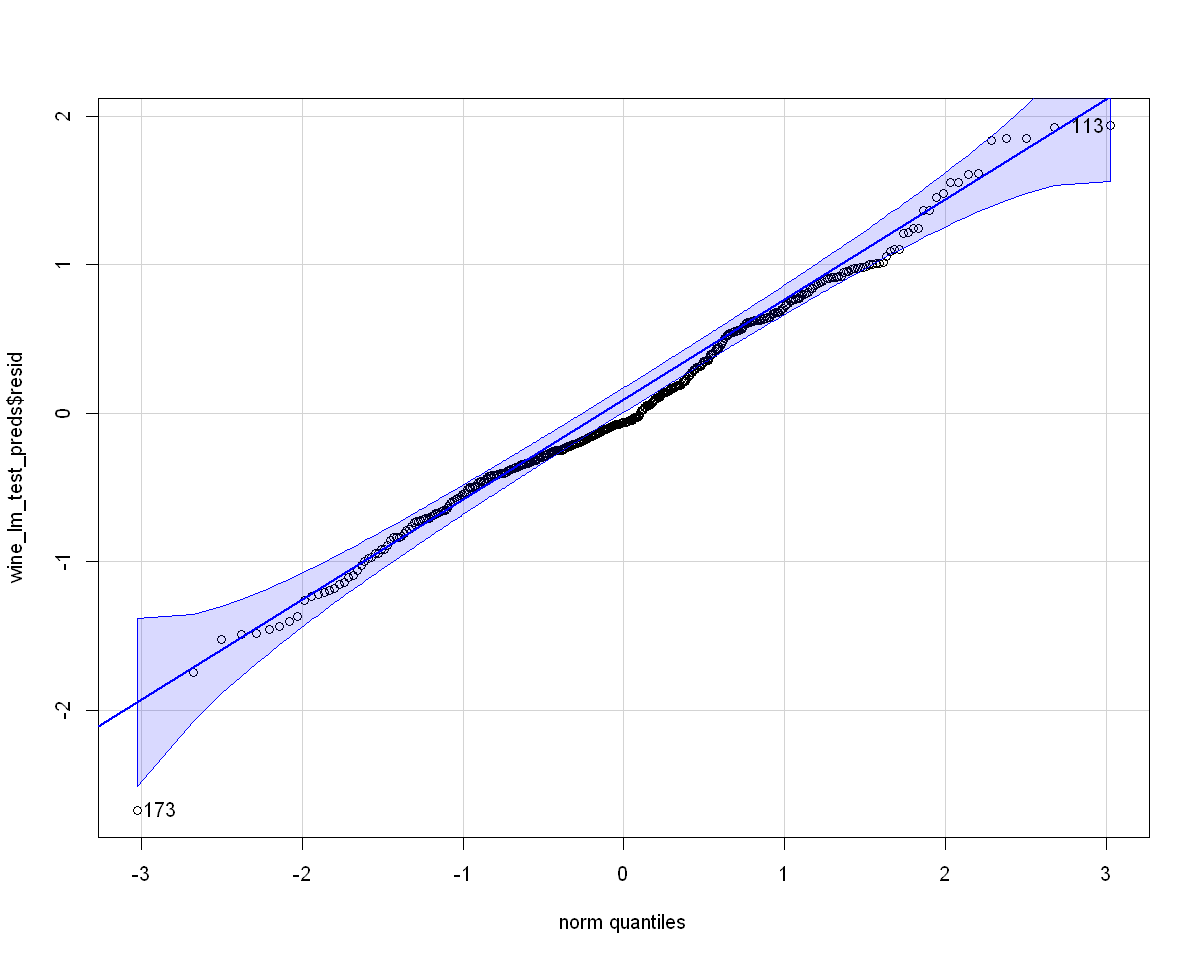

In [22]:
options(repr.plot.width = 10, repr.plot.height = 8)

wine_lm_test_preds <- wine_lm_fit %>%
  predict(wine_test) %>%
  bind_cols(wine_test) %>%
  mutate(resid = quality - .pred)

qqPlot(wine_lm_test_preds$resid)

> *Figure 4. Quantile-quantile plot of the model's erros.*

Plotting a quantile-quantile plot for the errors, it appears good. There does appear to be a dip from the line near quantiles = 0, and there appears to be a few outliers, but overall the normality assumption on our data is reasonable.

## 4. Discussion

### 4.1. Summary and Expectations

### 4.2. Impacts and Future Questions

The multivariate regression analysis conducted on the wine quality dataset aimed to uncover the impacts of various factors such as the alcohol content, the acidity, and the amount of sugar on the overall quality of wine. While the accuracy of our model is a bit mediocre at best, it is still a valuable analysis that can uncover proposals of changing winemaking practices and consumer preferences.

Future research should attempt to improve the accuracy of our model, such as incorporating better model selection techniques such as stepwise regression, or to restrict the coefficients through LASSO or Ridge regression. Alternate strategies could be to adapt a non-parametric (i.e. classification) analysis rather than a regression analysis on the data. More data could also be collected to further the amount of predictors and the amount of data there are. For those who are in the winemaking business, this should propose implications on alternate winemaking techniques to better increase the quality of the wine that is being manufactured, and may ask why some qualities negatively affect the quality of the wine and why others positively affect the quality.

## 5. References

<div class="csl-bib-body" style="line-height: 2; margin-left: 2em; text-indent:-2em;">
  <div class="csl-entry">Cortez, P., Cerdeira, A., Almeida, F., Matos, T., &amp; Reis, J. (2009). Modeling wine preferences by data mining from physicochemical properties. <i>Decision Support Systems</i>, <i>47</i>(4), 547–553. https://doi.org/10.1016/j.dss.2009.05.016</div>
  <div class="csl-entry"><i>Culture of wine</i>. (n.d.). Retrieved 29 February 2024, from https://www.wineinmoderation.eu/culture</div>
  <div class="csl-entry">Elfman, Z. (2017, January 6). <i>Libation frontiers – a deep dive into the world wine industry | toptal®</i>. Toptal Finance Blog. https://www.toptal.com/finance/market-sizing/wine-industry</div>
  <div class="csl-entry">Luque, A., Mazzoleni, M., Zamora-Polo, F., Ferramosca, A., Lama, J. R., &amp; Previdi, F. (2023). Determining the importance of physicochemical properties in the perceived quality of wines. <i>IEEE Access</i>, <i>11</i>, 115430–115449. https://doi.org/10.1109/ACCESS.2023.3325676</div>
</div>